## Bayes for Business Applications

This notebook is intended to explore how Bayesian models can be used in a business context, and how real-time data can be leveraged to improve models and make strategic decisions. As a case study, I will set up a series of hypothetical ads and explore how to draw on internet traffic data (e.g. click rates) to improve the probability mass function (PMF) to identify the best ad campaign to run. In theory, other KPIs could also be used following a similar approach.

**Advatages to a Bayesian approach:**

Applying Bayesian tools to explore the data makes interpretability more intuitive and allows users to integrate context and background knowledge (priors) into the model. **Generating these priors can lead to a very important and informative conversation with stakeholders and help them to understand what we are doing.** While we allow the experts to inform the model, the model learns and is update as a result of real data, and so ultimately will converge to results that represent the statistics of the problem at hand.
<img src="./bayes.png" width="350">
**Objectives:** 
- **Translate** bussiness insights into a distributions and models. Here, I will use the bandit model to define a liklihood function associated with the click rate of ads on fictisious website. 
- **Develop an intuition** for the amount of data necessary to develop confidence in the Bayesian models.
- **Propose** an approach to collect data _on the fly_ and prioritize promising ads.

After computing the posterior distribution, we then have access to a powerful statistical intuition about a problem:

- **High density interval (HDI)**: 95% certainty in a certain range
- **Quantifying risks**: identifying probability that KPI shows a decrease, probability above or below management defined thresholds.


### AB Testing (Bandit Problem)

A single-armed bandit problem has the same likelihood function as a coin flip given a binary event (heads or tails, win or lose, click or no click). Here to explore the effectiveness of a certain ad, I will use a Bayesian approach to model the bandit problem: **for each view, what is the probability that users will click on that ad?**

In [104]:
from empyrical_dist import Pmf
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Image
from scipy.stats import beta

import warnings
warnings.simplefilter("ignore")
#import pytest

sns.set_style('white')
sns.set_context('talk')

In [105]:
def decorate_bandit(title):
    """Labels the axes. Function from https://github.com/AllenDowney/
    
    title: string
    """
    plt.xlabel('Probability of Click')
    plt.ylabel('PMF')
    plt.title(title)

#### Task 1: Define the likelihood function

To use the Bayes update rule, there must be some way to link the data/observation to the probability associated with a specific hypothesis. In the case of the bandit problem where the hypothesis itself is a probability of a specific event, the likelihood returns a very simple expression: if 'True' (i.e. 'C' or click), *the likelihood is the hypothesis*, otherwise it returns the complement.

In [106]:
def likelihood_bandit(data, hypothesis):
    """ Likelihood function for the 'bandit' problem
    
    data: string, 'C' or 'N' for 'click' and 'no click'
    hypothesis: probability of an ad click (0-100)
    
    returns: float, probability
    
    """
    
    x = hypothesis / 100
    if data == 'C':   #True Event
        return x
    else:             #False Event
        return 1-x

Given no information about the situation, let us assume that our prior will be a constant PMF for all probabilities (0-100) of clicks. The prior beliefs could be updated and improved based on background information. For example, a beta distribution could be used to skew the data.

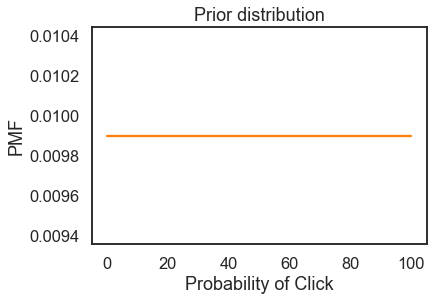

In [107]:
priorBelief = Pmf.from_seq(range(101))
priorBelief.plot()
decorate_bandit('Prior distribution')

#### Task 2: Use existing data to update the model

From the data, we can link to when users are exposed to a certain ads and the result of their experience: click ('C') or no click ('N'). Say for example, that in the first ten visits to the site, only one person clicks the advertisement. The model is updated for each observation. After ten updates, we begin to have a distribution which centers around 10% of the time, but the uncertainty remains large given the small number of 'outcomes.'

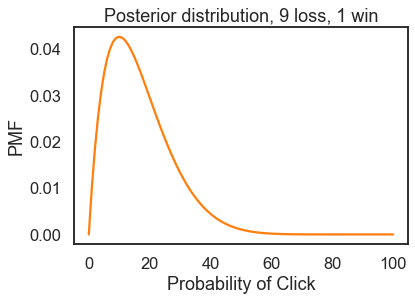

In [108]:
#Loop through data for clicks and no clicks and update the model generating a new posterior distribution
data = 'NNNNNNCNNN'
for outcome in data:
    priorBelief.update(likelihood_bandit, outcome)
    
priorBelief.plot()
decorate_bandit('Posterior distribution, {} loss, {} win'.format(data.count('N'),data.count('C')))

### Simultaneously considering different ads

This model can be applied to a set of different ads running in parallel to identify which is most promising (leads to the highest click rates. Here, we assume we have already collected data (e.g. live data, focus group, etc.), and in this case, the modelling is performed *a posteriori*.  We assume we have one thousand observations for each ad. Here the click rates are randomly assigned (between a min and a max value) to generate the data to provide to the model, but are not compared to the posterior until the end.

In [8]:
group_size = 1000  #assume 1000 observations
number_ads = 4     #number of ads (bandits) considered

clickRateMin, clickRateMax = (0.2,0.45)

clickData = np.random.rand(number_ads,group_size)    #generate random numbers
clickRates = (clickRateMax - clickRateMin)* np.random.rand(number_ads,1) + clickRateMin    
                                             #random click rates to be used as thresholds to generate data.
                                             #To remain unknown until after the Bayesian model 
                                             #has been constructed.
    

In [9]:
successes = np.zeros(number_ads)
failures = np.zeros(number_ads)

data_strings = []

"""
Generating hypothetical data "C" or "N" (click or not clicked) for each ad given the
randomly generated click rates.
"""
for i,ad in enumerate(clickData):
    
    #Generate string to pass into Bayesian update
    clickDataStr = np.asanyarray(ad,dtype=str)
    clickDataStr[ad <= clickRates[i]] = 'C'
    clickDataStr[ad > clickRates[i]] = 'N'
    data_strings.append(''.join(clickDataStr.tolist()))
    
    #Compute successes and failures
    successes[i] = sum(ad < clickRates[i]); failures[i] = group_size - successes[i]
    

In [10]:
def plot(prior, trueValues=None):
    """ Plotting the distribution for each of the bandits. Automatically adjusts the grid
        based on the number of priors.
    
        prior: list of Pmf objects (len of number_ads)
        trueValues: (optional) the values of the click rates used to generate the data.
                    To be plotted as a vertical dotted line as a reference.
    
    """
    
    # Adjust the number of rows and columns based on the number of priors to plot
    nRows = int(np.floor(np.sqrt(len(prior))))
    nCols = int(len(prior)/nRows) if len(prior)%nRows==0 else int(len(prior)//nRows + 1)
    
    sns.set_context('paper')
    
    #Loop through the priors and plot
    for i,b in enumerate(prior):
        plt.subplot(nRows,nCols,i+1)
        b.plot(label='Ad {}'.format(i+1))
        plt.legend()
        
        #Add reference values if provided.
        if trueValues:
            plt.axvline(x=trueValues[i],linestyle='--')
            
        
        
    plt.tight_layout()
    sns.set_context('talk')


In [11]:
#Generate prior beliefs for each of the ads. Here, we do not start with any particular insight, and instead
#assume uniform probability.
prior = [Pmf.from_seq(range(101)) for i in range(number_ads)]

As before, I am not providing any particular background information to the model and all possible click rates are equally likely. Knowning the min and max values of click rates, I could create an initial distribution that was centered in this range and for which a greater probability was assumed. Nonetheless, the Bayesian model will start with a constant pmf.

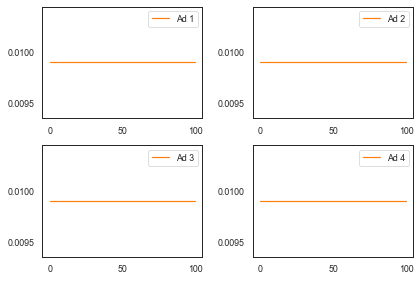

In [12]:
plot(prior)

In [13]:
means = []
for i, data in enumerate(data_strings):
    for outcome in data:
        prior[i].update(likelihood_bandit, outcome)
        means.append(prior[i].mean())
    print("Ad #{}: mean = {}, credible interval of 95% = {}".format(i+1,prior[i].mean(),
                                                                    prior[i].credible_interval(0.95)))

Ad #1: mean = 41.417165668662705, credible interval of 95% = [38. 44.]
Ad #2: mean = 33.53293413173655, credible interval of 95% = [31. 36.]
Ad #3: mean = 20.958083832335863, credible interval of 95% = [19. 23.]
Ad #4: mean = 36.826347305389234, credible interval of 95% = [34. 40.]


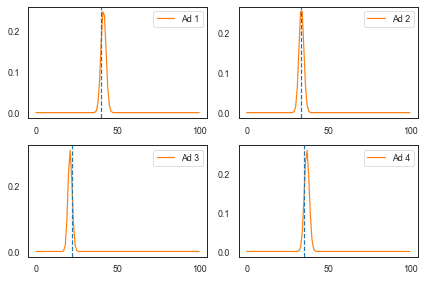

In [14]:
plot(prior,trueValues=(clickRates*100).tolist())

In [16]:
print((clickRates*100).tolist()) # Compare to the originally randomly generated click-rates

[[39.78160579137946], [33.09321072597815], [22.37062103540178], [34.875902004993584]]


#### How much data is needed to be confident about a model (or making a decision with a calculated amount of risk)?

This question requires us to observe the performance of the model as a function of the amount of data that it has seen. I will explore this for only one ad.

In [35]:
means = []; credibleIntervalsUpper = []; credibleIntervalsLower = []; posteriors = [];

group_sizes = [10,100,500,1000,5000,10000]

for group_size in group_sizes:
    
    number_ads = 1     #number of ads (bandits) considered

    clickRateMin, clickRateMax = (0.2,0.45)

    clickData = np.random.rand(number_ads,group_size)    #generate random numbers
    np.random.seed(88888)
    clickRates = (clickRateMax - clickRateMin)* np.random.rand(number_ads,1) + clickRateMin    
                                             #random click rates to be used as thresholds to generate data.
                                             #To remain unknown until after the Bayesian model 
                                             #has been constructed.
                
    successes = np.zeros(number_ads)
    failures = np.zeros(number_ads)

    data_strings = []

    for i,ad in enumerate(clickData):
    
        #Generate string to pass into Bayesian update
        clickDataStr = np.asanyarray(ad,dtype=str)
        clickDataStr[ad <= clickRates[i]] = 'C'
        clickDataStr[ad > clickRates[i]] = 'N'
        data_strings.append(''.join(clickDataStr.tolist()))
    
    
        #Compute successes and failures
        successes[i] = sum(ad < clickRates[i]); failures[i] = group_size - successes[i]
        
        prior = [Pmf.from_seq(range(101)) for i in range(number_ads)]
        
        for j, data in enumerate(data_strings):
            for outcome in data:
                prior[j].update(likelihood_bandit, outcome)
                
            posteriors.append(prior[i])
            means.append(prior[i].mean())
            credibleIntervalsLower.append(prior[i].credible_interval(0.95)[0]-means[-1])
            credibleIntervalsUpper.append(prior[i].credible_interval(0.95)[1]-means[-1])

    
            print("#Data = {} : mean = {}, credible interval of 95% = [{},{}]".format(group_size,
                                                                                 means[-1],
                                                                                 credibleIntervalsLower[-1],
                                                                                 credibleIntervalsUpper[-1]))

print("\n The actual click rate of the ad is {}".format(clickRates*100)[0][0])

#Data = 10 : mean = 41.66666666346026, credible interval of 95% = [-24.666666663460262,27.333333336539738]
#Data = 100 : mean = 43.13725490196079, credible interval of 95% = [-9.137254901960787,9.862745098039213]
#Data = 500 : mean = 34.661354581673336, credible interval of 95% = [-3.6613545816733364,4.338645418326664]
#Data = 1000 : mean = 35.3293413173653, credible interval of 95% = [-3.329341317365298,2.670658682634702]
#Data = 5000 : mean = 36.68583320866815, credible interval of 95% = [-1.68583320866815,1.31416679133185]
#Data = 10000 : mean = 36.76218495611296, credible interval of 95% = [-0.7621849561129608,1.2378150438870392]




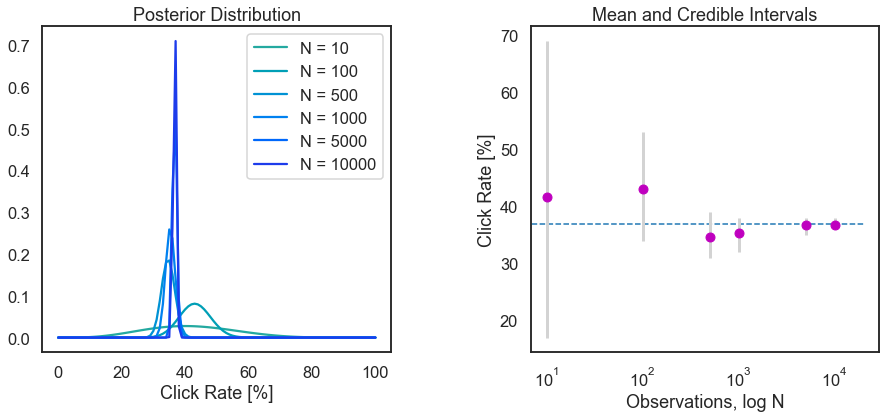

In [97]:
#Visualize the evolution of the posterior distribution as the model has seen more data 

colors = [
    "#24a9a0",
    "#009fb6",
    "#0092d4",
    "#0081f0",
    "#0068fb",
    "#1d3ceb"]


f = plt.figure(figsize=(15,6))
plt.subplots_adjust(wspace = 0.4)

### Figure 1a: Posterior Distribution by N 
ax = f.add_subplot(121)
ax.set_title("Posterior Distribution")
ax.set_xlabel("Click Rate [%]")

for i, posterior in enumerate(posteriors):
    ax.plot(posterior,color=colors[i], label='N = {}'.format(group_sizes[i]));
    
plt.legend();

### Figure 1b: Mean and Errors associated with Posterior Distribution
ax2 = f.add_subplot(122)
ax2.set_title("Mean and Credible Intervals")
ax2.set_xlabel("Observations, log N")
ax2.set_ylabel("Click Rate [%]")


ax2.hlines(y=clickRates*100.0,xmin=0,xmax=max(group_sizes)*2, lw=1.5, linestyle="--")
ax2.errorbar(group_sizes, means, yerr=[-1.0*np.asarray(credibleIntervalsLower),credibleIntervalsUpper], fmt='o', color='m',
             ecolor='lightgray', elinewidth=3, capsize=0);
ax2.set_xscale('log')


We can see from the plots above that the posterior distribution narrows, and around N=500 the mean and credible intervals begin to approach the actual click rate (blue dashed line). The random seed was fixed for this exercise, so the rate of conversion depends on the initial data the model learns from. Ultimately, however, all of these models will converge to the true value.

### Thompson Sampling

Generating the models above meant investing resources and showing ads that ultimately were not beneficial. Improved sampling methods can update the models and focus on improving the models while simultaneously prioritizng those choices (e.g. ads) which yield the highest probability (e.g. click rates).

In the case of assessing the ad compaigns, Thompson sampling chooses an add at random based on the probabilities based on the model's current beliefs. Algorithmically, this is done by drawing a value at random from the current posterior distribution and then updating using the Bayesian rule using the highest probability. 

In [111]:
def highestValue(distributions):
    """Provided a list of distributions, draw randomly from each distribution and return the distribution
    with the highest value.
    
    returns: index of the distribution whose random value is the highest
    """
    prob = [distribution.choice() for distribution in distributions]
    return np.argmax(prob)

def thompsonUpdate(beliefs, trueProbs):
    """
    [1] Chooses an ad based on the highestValue function (random sample),
    [2] performs a Monte Carlo step based on the true click rate,
    [3] and updates the model using Bayes rule.
    
    beliefs: list of probability distributions
    
    """
    # [1] choose an ad
    ad = highestValue(beliefs)
    
    # [2] Monte Carlo using true click rate
    if np.random.random() < trueProbs[ad]:
        outcome = 'C' #Click
    else:
        outcome = 'N' #No click
    
    # [3] as before, update belief but for simulated result.
    beliefs[ad].update(likelihood_bandit, outcome)


In [135]:
group_size = 1000  #assume 1000 observations
number_ads = 6     #number of ads (bandits) considered
num_runs = number_ads * 500 #

clickRateMin, clickRateMax = (0.1,0.6)

clickData = np.random.rand(number_ads,group_size)    #generate random numbers
clickRates = (clickRateMax - clickRateMin)* np.random.rand(number_ads,1) + clickRateMin    
                                             #random click rates to be used as thresholds to generate data.
                                             #To remain unknown until after the Bayesian model 
                                             #has been constructed.

#Again, assume no particular insights into the initial beliefs
prior = [Pmf.from_seq(range(101)) for i in range(number_ads)]

Ad #1 has the highest click rate: 0.5151352117444995


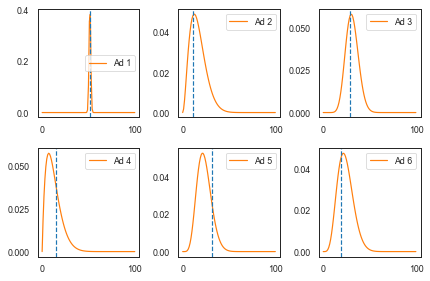

In [136]:
for run in range(num_runs):
    thompsonUpdate(prior,clickRates)
    
plot(prior,trueValues=(clickRates*100).tolist())
print("Ad #{} has the highest click rate: {}".format(np.argmax(clickRates)+1,np.max(clickRates)))

We can see from the example above that those ads which have the highest click rates are explored the most often and therefore have the narrowest distributions and thus the narrowest credible intervals. While it is true that there are ads whose means do not correspond to the true click rates, these ads do not encourage customers to click and should, in any case, be minimized. We sacrifice improving these models knowing that they are not the best choice to show to customers.